In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch
import numpy as np
import segmentation_models_pytorch as smp
import matplotlib
import scipy
from segmentation_models_pytorch import utils as smp_utils
import pandas as pd
from os.path import exists
from natsort import natsorted
from torchviz import make_dot

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [3]:
# abspath = os.path.abspath(__file__)
# dname = os.path.dirname(abspath)
# print('Current directory:', dname)
# os.chdir(dname)

In [4]:
DATA_DIR = './'

In [5]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_annot')

x_valid_dir = os.path.join(DATA_DIR, 'train')
y_valid_dir = os.path.join(DATA_DIR, 'train_annot')

x_test_dir = os.path.join(DATA_DIR, 'train')
y_test_dir = os.path.join(DATA_DIR, 'train_annot')

In [6]:
# helper function for data visualization
def visualize(image, mask):
    """PLot images in one row."""
    n = mask.shape[2]+1
    plt.figure(figsize=(n*6, 5))
    # for i, (name, image) in enumerate(images.items()):

    plt.subplot(1, n, 1)
    plt.xticks([])
    plt.yticks([])
    # plt.title(' '.join(name.split('_')).title())
    plt.imshow(image)
    
    cmaps = [
        matplotlib.colors.ListedColormap(['black', 'red']),
        matplotlib.colors.ListedColormap(['black', 'orange']),
        matplotlib.colors.ListedColormap(['black', 'blue']),
        matplotlib.colors.ListedColormap(['black', 'pink']),
        matplotlib.colors.ListedColormap(['black', 'green']),
        matplotlib.colors.ListedColormap(['black', 'yellow']),
        matplotlib.colors.ListedColormap(['black', 'red']),
    ]
    names = ['C', 'Ca', 'Mg', 'Na', 'O', 'S', 'Cl']
    
    for j in range(7):
        plt.subplot(1, n, j + 2)
        plt.xticks([])
        plt.yticks([])
        name = names[j]
        plt.title(name)
        plt.imshow(mask[:, :, j], cmap = cmaps[j], vmin=0, vmax=1)
    plt.show()

In [7]:
class Dataset(BaseDataset):
    """Setup Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.
    """

    def __init__(self, images_dir, masks_dir, augmentation=None, preprocessing=None):
        # list file names in the self.ids list
        self.sem_ids = os.listdir(images_dir)
        self.label_ids = os.listdir(masks_dir)
        
        self.sem_ids.sort()
        self.label_ids.sort()
        
        if self.sem_ids[0].startswith('.'):
            self.sem_ids.pop(0)
            
        if self.label_ids[0].startswith('.'):
            self.label_ids.pop(0)
        
        self.sem_ids = natsorted(self.sem_ids)
        self.label_ids = natsorted(self.label_ids)
        
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.sem_ids]
        self.masks_fps = [os.path.join(masks_dir, label_id) for label_id in self.label_ids]
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        image = cv2.imread(self.images_fps[i])
        # print(image.shape)
        # converting the file dimension in [N, C, H, W] order
        # image = np.transpose(image, (2, 0, 1))

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mat = scipy.io.loadmat(self.masks_fps[i])
        mask = mat['label']
        mask = np.transpose(mask, (1, 2, 0))
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        
    def __len__(self):
        return len(self.sem_ids)

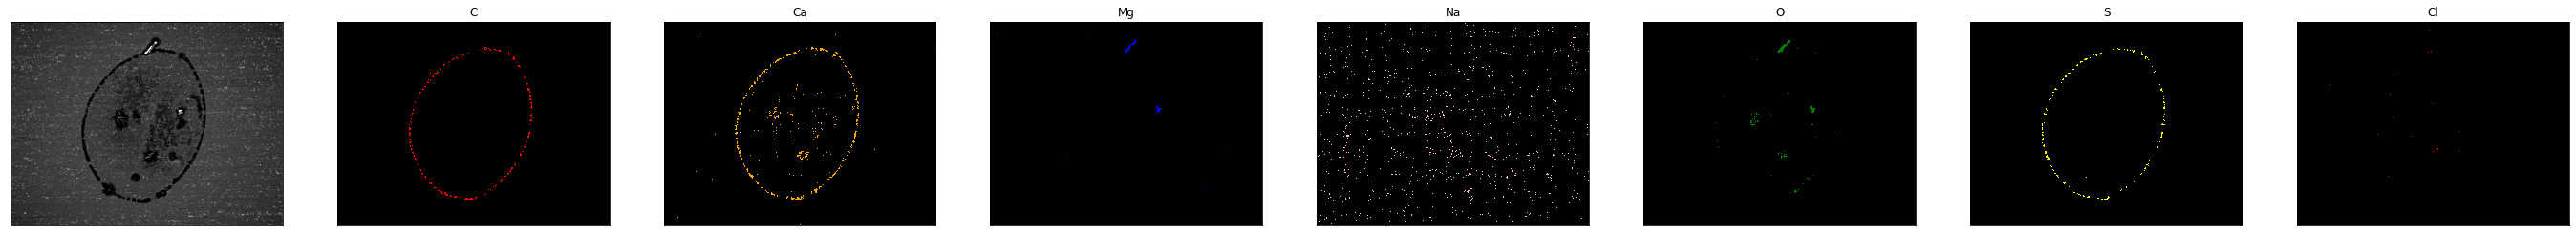

In [8]:
# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir)
image, mask = dataset[5]
visualize(
    image=image, 
    mask=mask.squeeze(),
)

In [9]:
def get_training_augmentation():
    
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),
        # albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        # albu.RandomCrop(height=320, width=320, always_apply=True),
        albu.GaussNoise(p=0.2),
        # albu.IAAPerspective(p=0.5),
        albu.Perspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                # albu.RandomBrightness(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.IAASharpen(p=1),
                albu.Sharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                # albu.RandomContrast(p=1),
                albu.RandomBrightnessContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)

In [10]:
def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    
    _transform = [
        # albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

(1920, 2560, 3) (1920, 2560, 7)


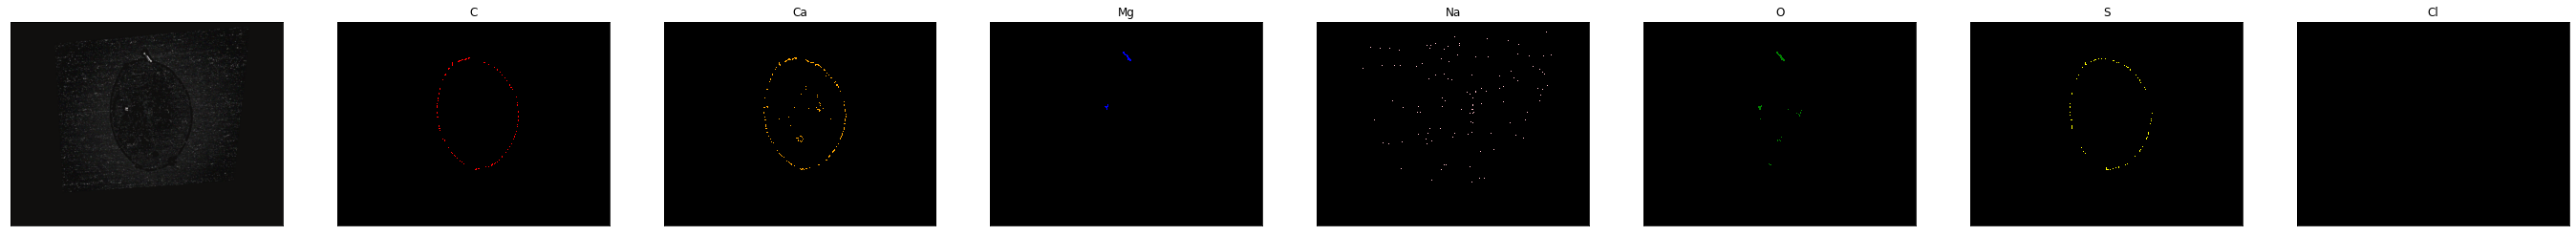

In [11]:
#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
)
image, mask = augmented_dataset[5]
print(image.shape, mask.shape)
visualize(image=image, mask=mask)

In [12]:
torch.cuda.empty_cache()
# torch.cuda.set_per_process_memory_fraction(0.9, 0)

ENCODER = 'se_resnext50_32x4d'
ENCODER_WEIGHTS = 'imagenet'
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

In [13]:
model = smp.Unet(
    encoder_name="resnet34", 
    encoder_weights='imagenet',
    classes = 7, 
    activation='sigmoid'
)

file_exists = exists('best_model.pth')
# if file_exists:
#     model = torch.load('./best_model.pth')
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [14]:
print(type(model))

<class 'segmentation_models_pytorch.decoders.unet.model.Unet'>


In [15]:
# print(model)

In [16]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

In [17]:
# create test dataset
test_dataset = Dataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
)

test_dataloader = DataLoader(test_dataset)

In [18]:
# test dataset without transformations for image visualization
test_dataset_vis = Dataset(
    x_test_dir, y_test_dir, 
)

In [19]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False, num_workers=0)

In [20]:
loss = smp.losses.DiceLoss("multilabel")
loss.__name__ = 'Dice_loss'

metrics = [
    smp_utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.01),
])

In [21]:
train_epoch = smp_utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True
)

valid_epoch = smp_utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True
)

In [22]:
max_score = 0

#################################
n = np.random.choice(len(train_dataset))

train_dataset_vis = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn)
)

In [23]:
# image_vis = train_dataset_vis[n][0].astype('uint8')
# image, gt_mask = train_dataset[n]

# gt_mask = gt_mask.squeeze()

# x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)

# pr_mask = model.predict(x_tensor)
# pr_mask = (pr_mask.squeeze().cpu().numpy().round())

In [24]:
# best_model = torch.load('./best_model.pth')

In [27]:
source, targets = next(iter(train_loader))
source = source.to(DEVICE)
yhat = model(source)

In [26]:
make_dot(yhat, params=dict(list(model_regression.named_parameters()))).render("EDS_mapping_torchviz", format="png")

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument weight in method wrapper___slow_conv2d_forward)


Epoch: 0
train: 100%|██████████| 157/157 [12:29<00:00,  4.78s/it, Dice_loss - 0.8621, iou_score - 0.08841]
Model saved!


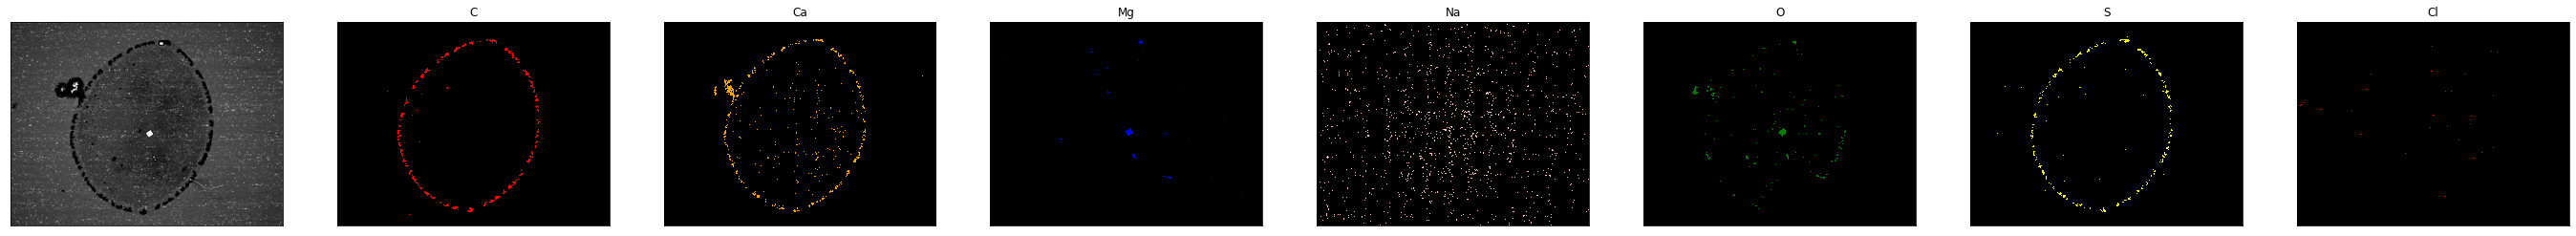

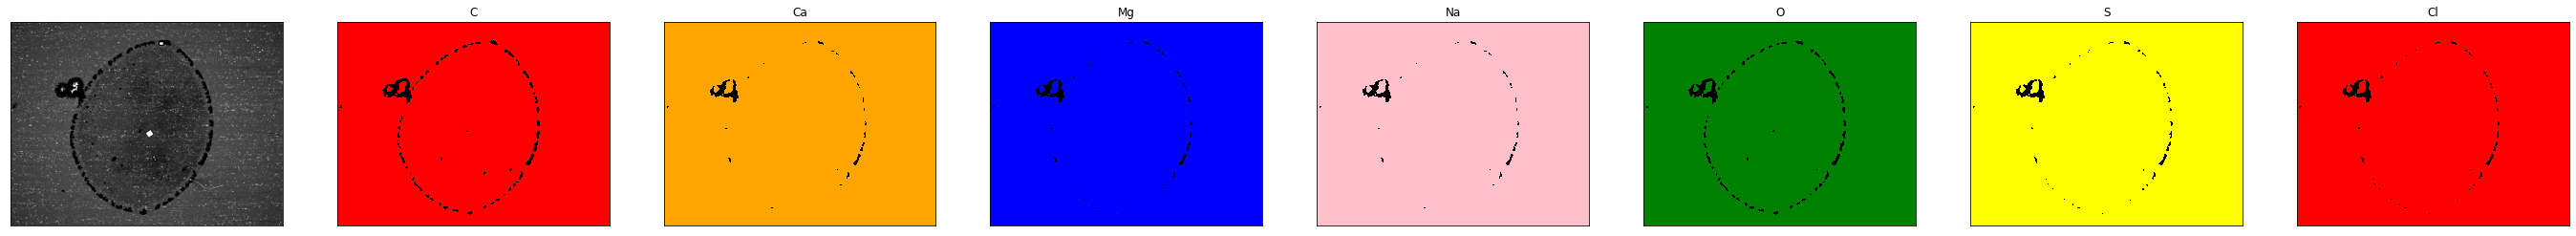


Epoch: 1
train: 100%|██████████| 157/157 [11:56<00:00,  4.57s/it, Dice_loss - 0.8615, iou_score - 0.09393]
Model saved!

Epoch: 2
train: 100%|██████████| 157/157 [11:44<00:00,  4.49s/it, Dice_loss - 0.861, iou_score - 0.09677] 
Model saved!

Epoch: 3
train: 100%|██████████| 157/157 [11:59<00:00,  4.58s/it, Dice_loss - 0.8618, iou_score - 0.09659]

Epoch: 4
train: 100%|██████████| 157/157 [11:59<00:00,  4.58s/it, Dice_loss - 0.8595, iou_score - 0.09353]

Epoch: 5
train: 100%|██████████| 157/157 [11:38<00:00,  4.45s/it, Dice_loss - 0.8594, iou_score - 0.09453]

Epoch: 6
train: 100%|██████████| 157/157 [11:52<00:00,  4.54s/it, Dice_loss - 0.8616, iou_score - 0.09318]

Epoch: 7
train: 100%|██████████| 157/157 [12:09<00:00,  4.65s/it, Dice_loss - 0.8621, iou_score - 0.09263]

Epoch: 8
train: 100%|██████████| 157/157 [12:03<00:00,  4.61s/it, Dice_loss - 0.8605, iou_score - 0.1001] 
Model saved!

Epoch: 9
train: 100%|██████████| 157/157 [11:49<00:00,  4.52s/it, Dice_loss - 0.8613, iou_score 

In [ ]:
for i in range(0, 1000):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    # valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < train_logs['iou_score']:
        max_score = train_logs['iou_score']
        torch.save(model, './best_model.pth')
        # print('Iou score:', max_score)
        print('Model saved!')
        
    # if i == 25:
    #     optimizer.param_groups[0]['lr'] = 1e-5
    #     print('Decrease decoder learning rate to 1e-5!')
        
    if i % 200 == 0:
        n = np.random.choice(len(test_dataset))
        image_vis = test_dataset_vis[n][0].astype('uint8')
        image, gt_mask = test_dataset[n]
        # image = np.transpose(image, (2, 0, 1))
        gt_mask = gt_mask.squeeze()
        x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
        x_tensor = x_tensor.float()
        best_model = torch.load('./best_model.pth')
        pr_mask = best_model.predict(x_tensor)
        pr_mask = pr_mask.squeeze().cpu().numpy().round()
        pr_mask = np.transpose(pr_mask, (1, 2, 0))

        gt_mask = np.transpose(gt_mask, (1, 2, 0))
        visualize(
            image=image_vis, 
            mask=gt_mask,
        )
        visualize(
            image=image_vis, 
            mask=pr_mask
        )

In [ ]:
EDS_predict_path = 'EDS_predict_path'

try: 
    os.mkdir(EDS_predict_path)
except OSError as error: 
    print(error)  

EDS_train_dir = os.path.join(DATA_DIR, 'EDS_predict_path')

In [ ]:
# for i in range(len(test_dataset)):
for i in range(5):
    for j in range(25):
        for k in range(5):
            image, gt_mask = test_dataset[i]
            # image = np.transpose(image, (2, 0, 1))
            gt_mask = gt_mask.squeeze()
            x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
            x_tensor = x_tensor.float()
            best_model = torch.load('./best_model.pth')
            pr_mask = best_model.predict(x_tensor)
            pr_mask = pr_mask.squeeze().cpu().numpy().round()
            image = np.transpose(image, (1, 2, 0))
            pr_mask = np.transpose(pr_mask, (1, 2, 0))
            # print(image.shape, pr_mask.shape) (1920, 2560, 3) (1920, 2560, 7)
            image_mask = np.concatenate((image, pr_mask), axis=2)
            np.save(EDS_predict_path+'/'+str(i)+'_'+str(j)+'_'+str(k)+'.npy', image_mask)

In [ ]:
# evaluate model on test set
test_epoch = smp_utils.train.ValidEpoch(
    model=best_model,
    loss=loss,
    metrics=metrics,
    device=DEVICE,
)

In [ ]:
logs = test_epoch.run(test_dataloader)
print(logs)

In [ ]:
calcium = pd.read_csv(r'ele_cons/Calcium.csv', header=None)
carbon = pd.read_csv(r'ele_cons/Carbon.csv', header=None)
chlorine = pd.read_csv(r'ele_cons/Chlorine.csv', header=None)
magnesium = pd.read_csv(r'ele_cons/Magnesium.csv', header=None)
oxygen = pd.read_csv(r'ele_cons/Oxygen.csv', header=None)
sodium = pd.read_csv(r'ele_cons/Sodium.csv', header=None)
sulphur = pd.read_csv(r'ele_cons/Sulphur.csv', header=None)

In [ ]:
calcium = np.reshape(calcium.to_numpy(), (125, 1))
carbon = np.reshape(carbon.to_numpy(), (125, 1))
chlorine = np.reshape(chlorine.to_numpy(), (125, 1))
magnesium = np.reshape(magnesium.to_numpy(), (125, 1))
oxygen = np.reshape(oxygen.to_numpy(), (125, 1))
sodium = np.reshape(sodium.to_numpy(), (125, 1))
sulphur = np.reshape(sulphur.to_numpy(), (125, 1))

In [ ]:
calcium = np.repeat(calcium, 5)
carbon = np.repeat(carbon, 5)
chlorine = np.repeat(chlorine, 5)
magnesium = np.repeat(magnesium, 5)
oxygen = np.repeat(oxygen, 5)
sodium = np.repeat(sodium, 5)
sulphur = np.repeat(sulphur, 5)

In [ ]:
calcium = np.reshape(calcium, (625, 1))
carbon = np.reshape(carbon, (625, 1))
chlorine = np.reshape(chlorine, (625, 1))
magnesium = np.reshape(magnesium, (625, 1))
oxygen = np.reshape(oxygen, (625, 1))
sodium = np.reshape(sodium, (625, 1))
sulphur = np.reshape(sulphur, (625, 1))

In [ ]:
elements = np.concatenate((calcium, carbon, chlorine, magnesium, oxygen, sodium, sulphur), axis=1)
np.save('elements.npy', elements)

Step two

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
# from utils import MyTrainDataset

import torch.multiprocessing as mp
from torch.utils.data.distributed import DistributedSampler
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.distributed import init_process_group, destroy_process_group
import os
from torch.utils.data import Dataset
import numpy as np
from torch.utils.data import DataLoader

In [ ]:
# def ddp_setup(rank, world_size):
#     """
#     Args:
#         rank: Unique identifier of each process
#         world_size: Total number of processes
#     """
#     os.environ["MASTER_ADDR"] = "localhost"
#     os.environ["MASTER_PORT"] = "12355"
#     init_process_group(backend="nccl", rank=rank, world_size=world_size)

In [ ]:
# class Trainer:
#     def __init__(
#         self,
#         model: torch.nn.Module,
#         train_data: DataLoader,
#         optimizer: torch.optim.Optimizer,
#         gpu_id: int,
#         save_every: int,
#     ):
#         self.gpu_id = gpu_id
#         self.model = model.to(gpu_id)
#         self.train_data = train_data
#         self.optimizer = optimizer
#         self.save_every = save_every
#         self.model = DDP(model, device_ids=[gpu_id])

#     def _run_batch(self, source, targets):
#         self.optimizer.zero_grad()
#         output = self.model(source)
#         loss = F.L1_LOSS(output, targets)
#         loss.backward()
#         self.optimizer.step()

#     def _run_epoch(self, epoch):
#         b_sz = len(next(iter(self.train_data))[0])
#         print(f"[GPU{self.gpu_id}] Epoch {epoch} | Batchsize: {b_sz} | Steps: {len(self.train_data)}")
#         self.train_data.sampler.set_epoch(epoch)
#         for source, targets in self.train_data:
#             source = source.to(self.gpu_id)
#             targets = targets.to(self.gpu_id)
#             self._run_batch(source, targets)

#     def _save_checkpoint(self, epoch):
#         ckp = self.model.module.state_dict()
#         PATH = "checkpoint.pt"
#         torch.save(ckp, PATH)
#         print(f"Epoch {epoch} | Training checkpoint saved at {PATH}")

#     def train(self, max_epochs: int):
#         for epoch in range(max_epochs):
#             self._run_epoch(epoch)
#             if self.gpu_id == 0 and epoch % self.save_every == 0:
#                 self._save_checkpoint(epoch)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, elements):
        self.data_dir = data_dir
        self.data_files = os.listdir(data_dir)
        self.data_files.sort()
        if self.data_files[0].startswith('.'):
            self.data_files.pop(0)
        
        self.elements = np.load(elements)

    def __len__(self):
        return len(self.data_files)

    def __getitem__(self, idx):
        data = np.load(self.data_dir + '/' + self.data_files[idx]) # (1920, 2560, 10)
        data = np.transpose(data, (2, 0, 1))
        elements = self.elements[idx]
        elements = np.float32(elements)
        return torch.tensor(data), torch.tensor(elements)

In [ ]:
dataset = CustomDataset('EDS_predict_path', 'elements.npy')
print(dataset[0][0].shape)
print(dataset[0][1].shape)

In [ ]:
class TheModelClass(nn.Module):
    def __init__(self):
        super(TheModelClass, self).__init__()
        self.conv1 = nn.Conv2d(10, 32, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.fc1 = nn.Linear(64 * 477 * 637, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 7)

    def forward(self, x):
        # print(x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        # print(x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        # print(x.shape)
        x = x.view(-1, 64 * 477 * 637)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model_regression = TheModelClass()
model_regression = model_regression.to('cuda')
print(model_regression)

In [ ]:
optimizer = torch.optim.SGD(model_regression.parameters(), lr=1e-3)
loss_func = nn.MSELoss()
dataloader = DataLoader(
    dataset,
    batch_size=4,
    shuffle=False,
)

In [ ]:
def run_test(model, data_loader):
    total_loss = 0
    j = 0
    for source, targets in dataloader:
        print(j)
        j = j + 1
        source = source.to('cuda')
        targets = targets.to('cuda')
        output = model_regression(source)
        loss = loss_func(output, targets)
        total_loss = total_loss + loss
    return total_loss

In [ ]:
for epoch in range(0, 1000):
    total_loss = 0
    for source, targets in dataloader:
        source = source.to('cuda')
        targets = targets.to('cuda')
        optimizer.zero_grad()
        output = model_regression(source)
        loss = loss_func(output, targets)
        total_loss = total_loss + loss
        loss.backward()
        optimizer.step()
    
    if epoch % 50 == 0:
        # total_loss = run_test(model_regression, dataloader)
        print(f"Epoch {epoch} | Loss: {total_loss}")